In [1]:
# 导包
import numpy as np
import import_ipynb
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torchvision import datasets, transforms
import torchvision
from matplotlib import pyplot as plt
from util.utils import plot_image, plot_curve, one_hot

# 数据集加载

In [2]:
# batch_size=200
batch_size=20
learning_rate=0.01
# epochs=10
epochs=2
criteon = nn.CrossEntropyLoss()

## 加载训练集

In [3]:
train_dataset = datasets.MNIST('./data/mnist/', 
    train=True, 
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        # transforms.RandomRotation([90, 180, 270]),
        transforms.RandomRotation(degrees=(-90, 90)),
        transforms.RandomRotation(degrees=(-180, 180)),
        transforms.RandomRotation(degrees=(-270, 270)),
        transforms.Resize([32, 32]),
        transforms.RandomCrop([28, 28]),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
print('train_dataset:', len(train_dataset))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print('train_dataset:', len(train_dataset), 'val_dataset:', len(val_dataset))
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=True)

train_dataset: 60000
train_dataset: 50000 val_dataset: 10000


## 加载测试集

In [4]:
test_dataset = datasets.MNIST('./data/mnist/', 
    train=False, 
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True)

torch.Size([20, 1, 28, 28]) torch.Size([20]) tensor(-0.4242) tensor(2.8215)


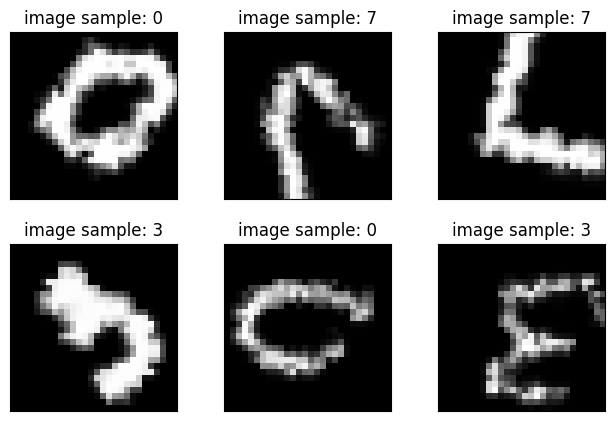

In [5]:
# 加载一批训练集数据
x, y = next(iter(train_loader))
print(x.shape, y.shape, x.min(), x.max())
plot_image(x, y, 'image sample')

# 不使用nn.Module

In [6]:
w1, b1 = torch.randn(200, 784, requires_grad = True), torch.randn(200, requires_grad = True)
w2, b2 = torch.randn(200, 200, requires_grad = True), torch.randn(200, requires_grad = True)
w3, b3 = torch.randn(10, 200, requires_grad = True), torch.randn(10, requires_grad = True)

In [7]:
torch.nn.init.kaiming_normal_(w1)
torch.nn.init.kaiming_normal_(w2)
torch.nn.init.kaiming_normal_(w3)

tensor([[ 0.1908,  0.1277,  0.1965,  ..., -0.1632, -0.1879,  0.1514],
        [-0.0618, -0.0645, -0.1057,  ..., -0.1746,  0.0579,  0.2211],
        [-0.1353,  0.1210,  0.2044,  ...,  0.0962, -0.0524,  0.0214],
        ...,
        [ 0.1856, -0.0605,  0.0502,  ...,  0.0324,  0.0962,  0.0266],
        [-0.0734, -0.2716, -0.0917,  ...,  0.0020, -0.0008, -0.0826],
        [ 0.0289,  0.0029, -0.0786,  ..., -0.1970,  0.0837,  0.1059]],
       requires_grad=True)

## 定义forward函数

In [8]:
def forward(x):
    x = x @ w1.t() + b1
    x = F.relu(x)
    x = x @ w2.t() + b2
    x = F.relu(x)
    x = x @ w3.t() + b3
    x = F.relu(x)
    return x

In [9]:
optimizer = optim.SGD([w1, b1, w2, b2, w3, b3], lr=learning_rate, weight_decay=0.01, momentum=0.9)
# 损失
train_loss = []

## 定义训练函数

In [10]:
def train_val(epochs, train_loader, val_loader):
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(-1, 28 * 28)
            # 预测值
            logits = forward(data)
            # 损失值
            loss = criteon(logits, target)
            # 梯度清零
            optimizer.zero_grad()
            # 梯度反向传播
            loss.backward()
            # print(w1.grad.norm(), w2.grad.norm())
            # 更新权重
            optimizer.step()
            train_loss.append(loss.item())
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))
        val_loss = 0
        correct = 0
        for data, target in val_loader:
            data = data.view(-1, 28 * 28)
            logits = forward(data)
            val_loss += criteon(logits, target).item()
            pred = logits.data.max(1)[1]
            correct += pred.eq(target.data).sum()
        val_loss /= len(val_loader.dataset)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))

In [11]:
train_val(epochs, train_loader, val_loader)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.764081
Train Epoch: 0 [2000/50000 (4%)]	Loss: 2.302585
Train Epoch: 0 [4000/50000 (8%)]	Loss: 2.302585
Train Epoch: 0 [6000/50000 (12%)]	Loss: 2.279476
Train Epoch: 0 [8000/50000 (16%)]	Loss: 2.305878
Train Epoch: 0 [10000/50000 (20%)]	Loss: 2.310437
Train Epoch: 0 [12000/50000 (24%)]	Loss: 2.305886
Train Epoch: 0 [14000/50000 (28%)]	Loss: 2.299267
Train Epoch: 0 [16000/50000 (32%)]	Loss: 2.342372
Train Epoch: 0 [18000/50000 (36%)]	Loss: 2.154256
Train Epoch: 0 [20000/50000 (40%)]	Loss: 2.279072
Train Epoch: 0 [22000/50000 (44%)]	Loss: 2.304066
Train Epoch: 0 [24000/50000 (48%)]	Loss: 2.336269
Train Epoch: 0 [26000/50000 (52%)]	Loss: 2.354141
Train Epoch: 0 [28000/50000 (56%)]	Loss: 2.391592
Train Epoch: 0 [30000/50000 (60%)]	Loss: 2.379699
Train Epoch: 0 [32000/50000 (64%)]	Loss: 2.371996
Train Epoch: 0 [34000/50000 (68%)]	Loss: 2.142936
Train Epoch: 0 [36000/50000 (72%)]	Loss: 2.343226
Train Epoch: 0 [38000/50000 (76%)]	Loss: 2.147028
Train Epoch

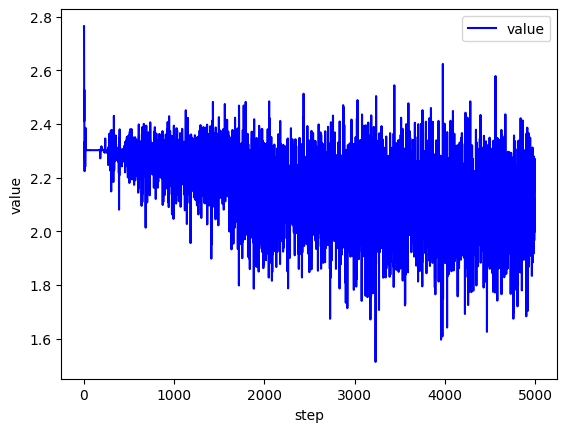

In [12]:
# 绘制损失曲线
plot_curve(train_loss)

## 定义测试函数

In [13]:
def test(test_loader):
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.view(-1, 28 * 28)
        logits = forward(data)
        test_loss += criteon(logits, target).item()
        pred = logits.data.max(1)[1]
        correct += pred.eq(target.data).sum()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
test(test_loader)


Test set: Average loss: 0.1104, Accuracy: 2218/10000 (22%)



# 使用nn.Module

In [15]:
x.shape

torch.Size([20, 1, 28, 28])

## 定义全连接神经网络（包含forward函数）

In [16]:
class MLP1(nn.Module):
    def __init__(self):
        super(MLP1, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 200),
            nn.BatchNorm1d(200),  # 使用BatchNorm2d
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.Linear(200, 200),
            nn.BatchNorm1d(200),  # 使用BatchNorm2d
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.Linear(200, 10),
            nn.BatchNorm1d(10),  # 使用BatchNorm2d
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
        )
    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
class MLP2(nn.Module):
    # 初始化
    def __init__(self):
        super(MLP2, self).__init__()
        # w1x+b1
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        # w2x+b2
        self.fc2 = nn.Linear(256, 64)
        self.bn2 = nn.BatchNorm1d(64)
        # w3x+b3
        self.fc3 = nn.Linear(64, 10)
        self.bn3 = nn.BatchNorm1d(10)
    # 前向
    def forward(self, x):
        # x: [b, 1, 28, 28]
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.bn3(self.fc3(x))
        return x

In [18]:
# device = torch.device("cpu")
device = torch.device("cuda:0")
net = MLP2().to(device)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.9)
# 损失
train_loss = []
criteron = nn.CrossEntropyLoss().to(device)

## 定义训练函数

In [19]:
def train_val(epochs, train_loader, val_loader, net, device):
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.view(-1, 28 * 28)
            data, target = data.to(device), target.to(device)
            # 预测值
            logits = net(data)
            # 损失值
            loss = criteon(logits, target)
            # 梯度清零
            optimizer.zero_grad()
            # 梯度反向传播
            loss.backward()
            # print(w1.grad.norm(), w2.grad.norm())
            # 更新网络参数
            optimizer.step()
            train_loss.append(loss.item())
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))
        val_loss = 0
        correct = 0
        for data, target in val_loader:
            data = data.view(-1, 28 * 28)
            data, target = data.to(device), target.to(device)
            logits = net(data)
            val_loss += criteon(logits, target).item()
            pred = logits.data.max(1)[1]
            correct += pred.eq(target.data).sum()
        val_loss /= len(val_loader.dataset)
        print('\nVal set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            100. * correct / len(val_loader.dataset)))
    torch.save(net.state_dict(), 'model/ckpt.mdl')

In [20]:
train_val(epochs, train_loader, val_loader, net, device)

Train Epoch: 0 [0/50000 (0%)]	Loss: 3.003771
Train Epoch: 0 [2000/50000 (4%)]	Loss: 1.807729
Train Epoch: 0 [4000/50000 (8%)]	Loss: 1.764304
Train Epoch: 0 [6000/50000 (12%)]	Loss: 1.903271
Train Epoch: 0 [8000/50000 (16%)]	Loss: 1.622461
Train Epoch: 0 [10000/50000 (20%)]	Loss: 1.535819
Train Epoch: 0 [12000/50000 (24%)]	Loss: 1.325863
Train Epoch: 0 [14000/50000 (28%)]	Loss: 1.534293
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.706233
Train Epoch: 0 [18000/50000 (36%)]	Loss: 1.414053
Train Epoch: 0 [20000/50000 (40%)]	Loss: 1.428542
Train Epoch: 0 [22000/50000 (44%)]	Loss: 1.886726
Train Epoch: 0 [24000/50000 (48%)]	Loss: 1.351868
Train Epoch: 0 [26000/50000 (52%)]	Loss: 1.508150
Train Epoch: 0 [28000/50000 (56%)]	Loss: 1.635309
Train Epoch: 0 [30000/50000 (60%)]	Loss: 1.416204
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.216959
Train Epoch: 0 [34000/50000 (68%)]	Loss: 1.492367
Train Epoch: 0 [36000/50000 (72%)]	Loss: 1.375567
Train Epoch: 0 [38000/50000 (76%)]	Loss: 2.040804
Train Epoch

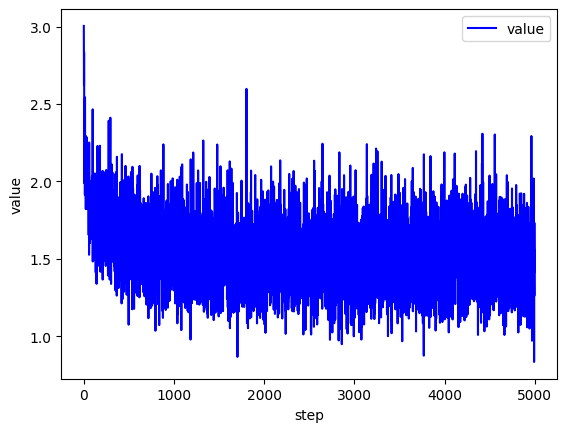

In [21]:
# 绘制损失曲线
plot_curve(train_loss)

## 定义测试函数

In [22]:
def test(test_loader, net, device):
    net.load_state_dict(torch.load('model/ckpt.mdl'))
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data = data.view(-1, 28 * 28)
        data, target = data.to(device), target.to(device)
        logits = net(data)
        test_loss += criteon(logits, target).item()
        pred = logits.data.max(1)[1]
        correct += pred.eq(target.data).sum()
        # 以上两行也可改为以下两行
        # pred = logits.argmax(dim=1)
        # correct += pred.eq(target).float().sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [23]:
test(test_loader, net, device)


Test set: Average loss: 0.0784, Accuracy: 4507/10000 (45%)



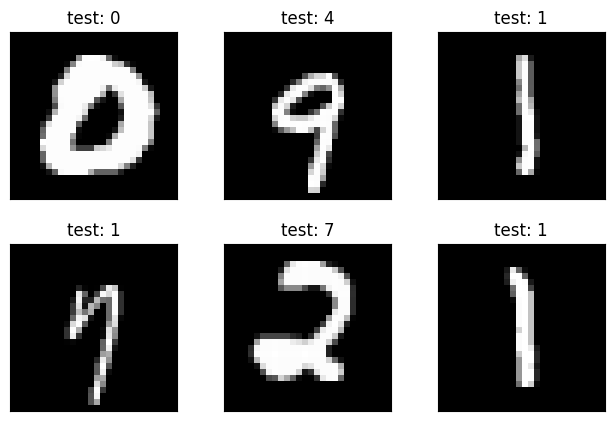

In [24]:
# 加载一批测试集数据
x, y = next(iter(test_loader))
# 调用模型
out = net(x.to(device).view(x.size(0), 784))
# 预测结果
pred = out.argmax(dim=1)
# 绘制测试集image
plot_image(x, pred, 'test')